# What Is NLP?
Natural Language Processing (NLP) is a set of methods for extracting information from text. But is text not already data and what would we extract? It is data, however it is represented as a continuous string of text like the one you are reading right now. The issue here is that statistics use numbers as input. So how do we make numbers out of text? Usually we break down the text into words. We can then one-hot encode the words and build a binary matrix. The columns of the matrix are the tokens, while the rows are the texts. We can then use the binary matrix as input to a range of numeric functions.

# Tokenization
Let us download a dataset of news articles from 20 news groups.

In [150]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

We can select a single news article and print its contents:

In [151]:
print(news.data[0])



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [152]:
news.data[0][-45:]

'\nregular season game.          PENS RULE!!!\n\n'

In [153]:
news.data[0].split()[-5:]

['regular', 'season', 'game.', 'PENS', 'RULE!!!']

However, note that the `game.` token also includes the punctuation at the end. The `RULE!!!` token is capitalized and includes the punctuation. Capitalization carries its own set of probles as it can make several distinct tokens out of the same sema. We could turn to another basic method for splitting text - regular expressions:

In [154]:
import re

In [155]:
def tokenize_regex(regex, text):
    return [t.lower() for t in re.split(regex, text) if t != '']

In [156]:
punct_whitesp = re.compile(r'\s|[\.\(\)\?\!]+')
tokenize_regex(punct_whitesp, news.data[0])[-5:]

['regular', 'season', 'game', 'pens', 'rule']

That looks even better. Note that we also made all tokens in lowercase such that `RULE` will match with `rule`. However, in reality, texts are rarely so clean. They contain:

* Special characters;
* Random new lines, tabs or other whitespace characters;
* Improperly scanned characters (e.g. '§' instead of 'S');
* Foreign words;
* Tpyos;

That's why an extensive work must be performed to clean the text and tokenize it. The tokenization methods may also differ depending on the subject matter, the types of texts and the qunatity of documents. Sometimes this task constitutes the bulk of the NLP work.

# Stemming
look at the following tokens: `go`, `going`. They represent different strings, but have the same meaning. What can we do about this?

In [157]:
porter = nltk.PorterStemmer()
for token in ['go', 'going']:
    print(f'The initial for is: {token}, but after stemming, it becomes: {porter.stem(token)}')

The initial for is: go, but after stemming, it becomes: go
The initial for is: going, but after stemming, it becomes: go


We can use this technique for text normalization if we want to focus on the meaning rather than the morphology of the text. The usefullness of the stemming technique is proportional to the text size and the morphological complexity.

# One-Hot Encoding
We can take our news dataset and build a matrix. The rows of the matrix will represent the various news articles, while the columns will represent a one-hot encoding of all the tokens for all news articles.

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

In [216]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern = r'[A-z]+', strip_accents='ascii', lowercase=True, stop_words='english')

In [217]:
vectorized_text = count_vectorizer.fit_transform(news.data)

In [218]:
first_article = pd.DataFrame(vectorized_text.getrow(0).todense(0), columns=count_vectorizer.get_feature_names()).loc[0]

Let us look at the top 10 tokens from the news article:

In [223]:
import matplotlib.pyplot as plt
# plt.style.use(['dark_background'])

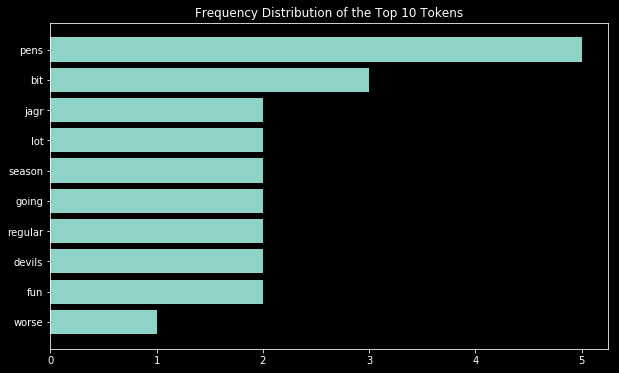

In [225]:
to_plot = first_article[first_article >= 1].sort_values()[-10:]
fig = plt.figure(figsize=(10, 6))
plt.barh(to_plot.index, to_plot.values)
plt.title('Frequency Distribution of the Top 10 Tokens')
plt.show()

As we can see, we can gain some insight from the most frequent terms in a text: `pens`, `jagr` and `season` imply that the article is about a sports match. In addition, we can also derive the literary complexity of the text by dividing the total number of tokens by the number of unique tokens. Our intuition here is that different genres of texts have different literary complexities (e.g. a simple note has a different complexity than a science article).

In [234]:
to_plot = first_article[first_article >= 1]
print(f'The literary complexity of the article is: {(1 - (len(to_plot) / to_plot.sum())):0.2%}')

The literary complexity of the article is: 20.31%


In [235]:
# plt.plot(x, y, "b|", scalex=0.1)
# plt.yticks(list(range(len(words))), words, color="b")
# plt.ylim(-1, len(words))
# plt.title('Dispersion Plot')
# plt.xlabel("Word Offset")
# plt.show()

# TFIDF
Suppose we have a group of texts. We want to figure out what are the important terms in each text. That will allow us to infer what the text is about. How can we achieve that? Intuition tells us that terms that are generally rare throughout a corpus (a group of texts), but are frequent in a particular text could be the most important. We can express this intuition as:

$tfidf(t, d, D) = tf(t, d) idf(t, D)$

Where $tf(t, d)$ is the term frequency for a single document. It is defined as:

$tf(t, d) = 0.5 + 0.5\frac{f(t, d)}{max \{f_{t', d} : t' \in d \}}$

The inverse corpus document frequency $idf(t, D)$ is defined as:

$idf(t, D) =  log \frac{N}{|\{d \in D : t \ d\}|}$

Hence the etymology of the name - term frequency inverse document frequency (TFIDF). Let's appy this method to our text:

In [287]:
from sklearn.feature_extraction.text import TfidfTransformer

In [288]:
tfidf_transformer = TfidfTransformer()

In [289]:
tfidf = tfidf_transformer.fit_transform(vectorized_text)

We can now show the 3 most important terms for each text:

In [294]:
from collections import defaultdict
tfidf_result = defaultdict(list)

top_n = 3

for i, line in enumerate(news.data[:top_n]):
    tfidf_result['doc'].append(line)
    for j in range(top_n):
        feature_names = count_vectorizer.get_feature_names()
        term_df = test_df = pd.DataFrame(tfidf.getrow(i).todense(),
                                         columns=feature_names)
        term = term_df.loc[0].sort_values(ascending=False).reset_index()
        tfidf_result[f'term_{j+1}'].append(term.loc[j].values[0])
        tfidf_result[f'importance_{j+1}'].append(term.loc[j].values[1])

In [295]:
pd.DataFrame(tfidf_result)

,doc,term_1,importance_1,term_2,importance_2,term_3,importance_3
0,\n\nI am sure some bashers of Pens fans are pr...,pens,0.548249,jagr,0.250491,devils,0.218444
1,My brother is in the market for a high-perform...,pro,0.293923,bus,0.289536,farenheit,0.281321
2,\n\n\n\n\tFinally you said what you dream abou...,azerbadjan,0.355673,weapons,0.279686,armenians,0.231632


That is an even better way to gain insight into the semantics of each text. Let us look at our original example (the article about the sports match). In this case, the 3 most important terms are `pens`, `jagr` and `devils` - the names of the competing teams and the university to which the host belongs. This is a much better result than the one achieved by simple term frequency.

We can use the importance of the tokens from all texts in order to group them by semantics. This will allow us to see articles belonging to the same category or topic.

# K-Means Clustering
We can use an unsupervised learning algorithm to automatically group texts by their meaning.

# Word2Vec